# Linear Extrapolation with non-linear algorithms

#### Summary
 * [Interpolation](#interpolation)
 * [Extrapolation](#extrapolation)
    * [Feature engineering done right](#feature-engineering-done-right)
 * [Why any of this complexity would be useful](#why-any-of-this-complexity-would-be-useful)

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from utils.charts import display_static_altair_images

## Interpolation

When modeling data, we are inclined to think of independent variables first, then constant later:

$$ y = ax + b $$

This approach is very useful when trying to understand what the data says. However, when we need to predict stuff, it is useful to do the opposite:

$$ y = b + ax $$

Now the constant is the first term and it is telling you it is the priority. Thanks to the commutative property of sum, we can legally do that and change nothing about our system! (yeah, you can think of that without rearranging the equation, I'm just trying to illustrate something here)



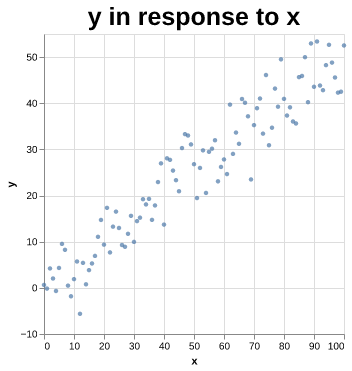

In [5]:
start = 0
stop = 100
num = stop - start + 1

a = 0.5
b = 0

rng = np.random.default_rng(seed=0)
mean, std = 0, 5

x = np.linspace(start, stop, num)
y = a * x + b + rng.normal(mean, std, num)

df = pd.concat((pd.Series(x, name="x"), pd.Series(y, name="y")), axis=1)

source = df

base = alt.Chart(source, title=alt.Title("y in response to x", fontSize=25)).encode(
    alt.Y("y:Q"),
)

point = base.mark_point(size=20, filled=True).encode(
    alt.X("x:Q"),
)

display_static_altair_images(point)

If we build a model on top of that data, we hope to obtain a straight line, so lets build a linear model using least squares method.

In [6]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

slope, intercept, r_value, p_value, std_err

(0.5083642516239775,
 0.0081414880559052,
 0.9516322051549063,
 1.5287822254627545e-52,
 0.016495497063371778)

If you aren't so sure, you can try polynomial fit!

In [7]:
for n in range(1, 4):
    coeffs = np.polyfit(x, y, n)
    print(coeffs)

[0.50836425 0.00814149]
[-9.21665571e-04  6.00530809e-01 -1.51260670e+00]
[-1.74108747e-05  1.68996564e-03  4.96584404e-01 -6.68005171e-01]


As we can see, anything bigger than the first degree is too small to be relevant, so we can trust in the previous result!

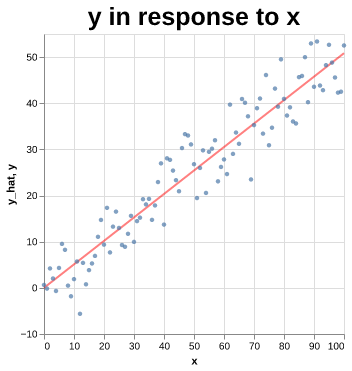

In [10]:
source = df.assign(y_hat=slope * df["x"] + intercept)

base = alt.Chart(
    source,
    title=alt.Title("y in response to x", fontSize=25),
).encode(
    alt.X("x:Q"),
)

point = base.mark_point(size=20, filled=True).encode(alt.Y("y:Q"))
line = base.mark_line(opacity=0.5, color="red").encode(alt.Y("y_hat"))

display_static_altair_images(line + point)

Now, imagine we want to build a tree-based model on top of this data

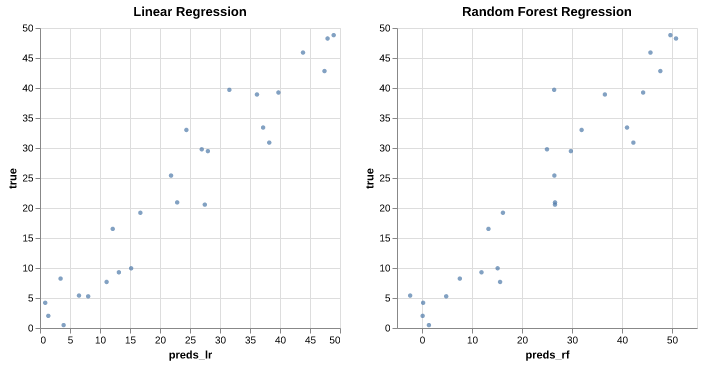

In [21]:
lr = LinearRegression()
rf = RandomForestRegressor(random_state=0)

X, y_ = df.filter(["x"]), df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y_, random_state=0)

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

y_pred_rf, y_pred_lr = rf.predict(X_test), lr.predict(X_test)

source = pd.concat(
    (
        pd.Series(y_pred_lr, name="preds_lr"),
        pd.Series(y_pred_rf, name="preds_rf"),
        pd.Series(y_test.reset_index(drop=True), name="true"),
    ),
    axis=1,
)

base = alt.Chart(source).mark_point(size=20, filled=True).encode(alt.Y("true:Q"))

point_lr = base.encode(alt.X("preds_lr:Q")).properties(title="Linear Regression")
point_rf = base.encode(alt.X("preds_rf:Q")).properties(title="Random Forest Regression")

display_static_altair_images(point_lr | point_rf)

Both models did an ok job when predicting in the interpolation section of the sample.

## Extrapolation

Now, lets just imagine that the tree-based model achieved stellar metrics while the linear model did ok but not so great. The data scientist would send to production the tree-based model.

But wait, tree-based models are known to not extrapolate well! We can't just use them lightly.

Imagine that it is expected that the data would continue the pattern of growing linearly, that means if $x = 200$ we would expect $y = 100 + \varepsilon$

/home/sorin/datascience/datascience-done-right/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/sorin/datascience/datascience-done-right/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


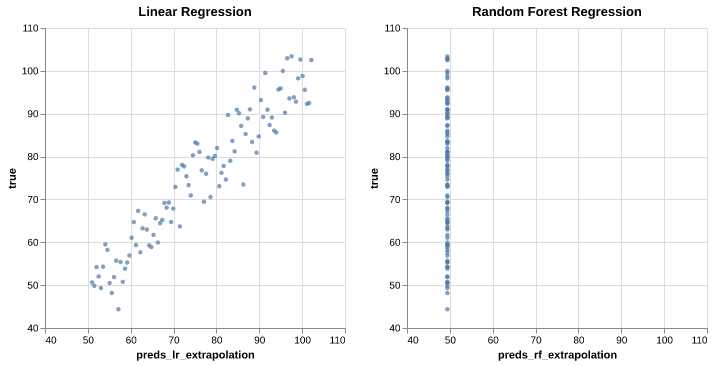

In [22]:
start_extrapolation = 100
stop_extrapolation = 200
num_extrapolation = stop_extrapolation - start_extrapolation + 1

rng = np.random.default_rng(seed=0)
x_extrapolation = np.linspace(
    start_extrapolation, stop_extrapolation, num_extrapolation
)
y_extrapolation = a * x_extrapolation + b + rng.normal(mean, std, num)

y_pred_lr_extrapolation = lr.predict(x_extrapolation.reshape(-1, 1))
y_pred_rf_extrapolation = rf.predict(x_extrapolation.reshape(-1, 1))

source = pd.concat(
    (
        pd.Series(y_pred_lr_extrapolation, name="preds_lr_extrapolation"),
        pd.Series(y_pred_rf_extrapolation, name="preds_rf_extrapolation"),
        pd.Series(y_extrapolation, name="true"),
    ),
    axis=1,
)

base_extrapolation = (
    alt.Chart(source)
    .mark_point(size=20, filled=True)
    .encode(
        alt.Y("true:Q").scale(domain=[40, 110]),
    )
)

point_lr_extrapolation = base_extrapolation.encode(
    alt.X("preds_lr_extrapolation:Q").scale(domain=[40, 110]),
).properties(title="Linear Regression")
point_rf_extrapolation = base_extrapolation.encode(
    alt.X("preds_rf_extrapolation:Q").scale(domain=[40, 110]),
).properties(title="Random Forest Regression")

display_static_altair_images(point_lr_extrapolation | point_rf_extrapolation)

### Feature engineering done right

To keep using a tree-based model for this data we need feature engineering.

Feature engineering goes beyond the often done very wrong:
 * outlier removal;
 * filling missing data;
 * transforming continuous variables to normal distribution.

As we already know from the context of the data (learned from the business experience, from exploratory data analysis, etc) that it grows constantly based on `x`, we don't need to throw it in a algorithm and expect it to do our job. We as scientists can just modify the data to force the model to work as expected.

In [14]:
class TransformX:
    def __init__(self, constant: int | float, x: pd.Series, y: pd.Series):
        self.constant = constant
        self.x = x
        self.y = y

    def transform_data(self) -> tuple[np.ndarray, np.ndarray]:
        x_transformed = np.zeros(self.x.shape)
        y_transformed = self.y - self._constant_x()

        return x_transformed, y_transformed

    def post_predict(self) -> pd.Series:
        y_recovered = self.y + self._constant_x()

        return y_recovered

    def _constant_x(self) -> pd.Series:
        return self.constant * self.x

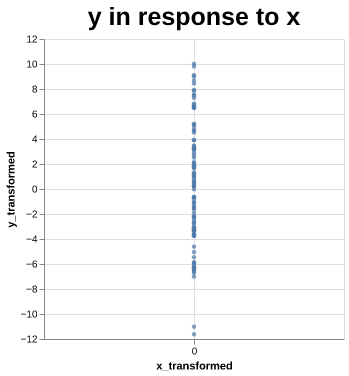

In [23]:
fe = TransformX(0.5, X["x"], y_)

x_fe, y_fe = fe.transform_data()

df_extrapolation = pd.concat(
    (
        pd.Series(x_fe, name="x_transformed"),
        pd.Series(y_fe, name="y_transformed"),
    ),
    axis=1,
)

source = df_extrapolation

base = alt.Chart(source, title=alt.Title("y in response to x", fontSize=25)).encode(
    alt.Y("y_transformed:Q"),
)

point = base.mark_point(size=20, filled=True).encode(
    alt.X("x_transformed:Q"),
)

display_static_altair_images(point)

Now we can see x as $x=0$ and y as $y=0+\varepsilon$. Lets build a new tree-based model capable extrapolation.

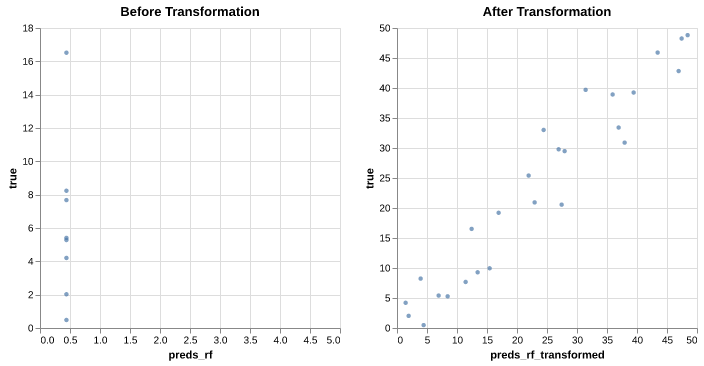

In [30]:
rf_extrapolation = RandomForestRegressor(random_state=0)

X, y_ = df.filter(["x"]), df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y_, random_state=0)

feature_engineering_train = TransformX(0.5, X_train["x"], y_train)
X_train_transformed, y_train_transformed = feature_engineering_train.transform_data()

feature_engineering_test = TransformX(0.5, X_test["x"], y_test)
X_test_transformed, y_test_transformed = feature_engineering_test.transform_data()

rf_extrapolation.fit(X_train_transformed.reshape(-1, 1), y_train_transformed)
y_preds_extrapolation = rf_extrapolation.predict(X_test_transformed.reshape(-1, 1))

transform_preds = TransformX(0.5, X_test["x"], y_preds_extrapolation)
y_preds_transformed = transform_preds.post_predict()

source = pd.concat(
    (
        pd.Series(y_preds_extrapolation, name="preds_rf"),
        pd.Series(y_preds_transformed, name="preds_rf_transformed"),
        pd.Series(y_test, name="true"),
    ),
    axis=1,
)

base_extrapolation = (
    alt.Chart(source).mark_point(size=20, filled=True).encode(alt.Y("true:Q"))
)

point_lr_extrapolation = base_extrapolation.encode(
    alt.X("preds_rf:Q").scale(domain=[0, 5]),
).properties(title="Before Transformation")
point_rf_extrapolation = base_extrapolation.encode(
    alt.X("preds_rf_transformed:Q").scale(domain=[0, 50]),
).properties(title="After Transformation")

display_static_altair_images(point_lr_extrapolation | point_rf_extrapolation)

In [29]:
start_extrapolation = 100
stop_extrapolation = 200
num_extrapolation = stop_extrapolation - start_extrapolation + 1

rng = np.random.default_rng(seed=0)
x_extrapolation = np.linspace(
    start_extrapolation, stop_extrapolation, num_extrapolation
)
y_extrapolation = a * x_extrapolation + b + rng.normal(mean, std, num)

feature_engineering_extrapolation = TransformX(0.5, x_extrapolation, y_extrapolation)
X_test_extrapolation, y_test_extrapolation = (
    feature_engineering_extrapolation.transform_data()
)

y_preds_extrapolation = rf_extrapolation.predict(X_test_extrapolation.reshape(-1, 1))

transform_preds_extrapolation = TransformX(0.5, x_extrapolation, y_preds_extrapolation)
y_preds_extrapolation_transformed = transform_preds_extrapolation.post_predict()

y_preds_extrapolation_transformed

source = pd.concat(
    (
        pd.Series(y_preds_extrapolation, name="preds_rf"),
        pd.Series(y_preds_extrapolation_transformed, name="preds_rf_transformed"),
        pd.Series(y_extrapolation, name="true"),
    ),
    axis=1,
)

base_extrapolation = (
    alt.Chart(source)
    .mark_point(size=20, filled=True)
    .encode(
        alt.Y("true:Q").scale(domain=[40, 110]),
    )
)

point_before_transformation = base_extrapolation.encode(
    alt.X("preds_rf:Q").scale(domain=[0, 5]),
).properties(title="Before Transformation")
point_after_transformation = base_extrapolation.encode(
    alt.X("preds_rf_transformed:Q").scale(domain=[40, 110]),
).properties(title="After Transformation")

display_static_altair_images(point_before_transformation | point_after_transformation)

alt.HConcatChart(...)

## Why any of this complexity would be Useful?

In this example we established the standard deviation $\sigma = 5$, that means roughly 95% of the data would be $y=\frac{1}{2}x \pm 10$. We followed this pattern to make it easier to visualize and explain.

Now, imagine we could explain more of the residue with more features and reduce the $\sigma$ to maybe 1 or 2... We would minimize most of the loss and get a better model.

However, adding more dimensions make it harder to conceptually model linear relationships. Also, we could have a situation in which most of the residue could be well explained by non-linear relationships, categories with too high cardinality, etc. This is the scenario in which the extra complexity explained here could be useful.

In the end, when deciding over using a complex method or not we need to consider how much the accuracy gained through the complexity helps the business achieve better results.